In [5]:
from __future__ import print_function

from datetime import datetime
import pickle
import warnings

from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import numpy as np
import pandas as pd
import seaborn as sns

import yfinance as yf
import os
# froom pathlib import Path

In [2]:
def obtain_prices_df(csv_filepath, symbol):
    """
    Obtain the prices DataFrame from the CSV file,
    filter by the end date and calculate the 
    percentage returns.
    """
    full_path = os.path.join(csv_filepath, f'{symbol}.csv')
    print(f' data full path: {full_path}')
    if not os.path.exists(full_path):
        data = yf.download(symbol)
        data.to_csv(full_path)
    df = pd.read_csv(
        full_path, header=0,
        names=[
            "Date", "Open", "High", "Low", 
            "Close", "Volume", "Adj Close"
        ],
        index_col="Date", parse_dates=True
    )
    df["Returns"] = df["Adj Close"].pct_change()
    df = df[:end_date.strftime("%Y-%m-%d")]
    df.dropna(inplace=True)
    return df


In [3]:
def plot_in_sample_hidden_states(hmm_model, df):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(rets)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            df["Adj Close"][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()


In [11]:
# Hides deprecation warnings for sklearn
warnings.filterwarnings("ignore")

sym="TLT"
# Create the SPY dataframe from the Yahoo Finance CSV
# and correctly format the returns for use in the HMM

start_date="1997-01-01"
end_date=datetime.today().strftime('%Y-%m-%d')
print("Getting daily close for \"{}\" from start date: {} to  end date: {}".format(sym, start_date, end_date))

Getting daily close for "TLT" from start date: 1997-01-01 to  end date: 2024-06-25


In [16]:
data = yf.download(sym, start=start_date, end=end_date)
print(data.head())

BASE_DIR = os.getcwd()
data_path = os.path.join(BASE_DIR, "data", "{}.csv".format(sym))
data.reset_index().to_csv(data_path)
print("Data file saved: {}".format(data_path))


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2002-07-30  81.750000  81.900002  81.519997  81.519997  39.197109    6100
2002-07-31  81.949997  82.800003  81.900002  82.529999  39.682789   29400
2002-08-01  82.540001  83.019997  82.540001  83.000000  39.908756   25000
2002-08-02  83.160004  84.099998  82.879997  83.849998  40.317451   52800
2002-08-05  84.040001  84.440002  83.849998  84.220001  40.495384   61100
Data file saved: /home/thomas/projects/Proof-Of-Concept/Quant_Analysis/data/TLT.csv


 data full path: /home/thomas/projects/Proof-Of-Concept/Quant_Analysis/data/QQQ.csv
Model Score: -646.3099795041202


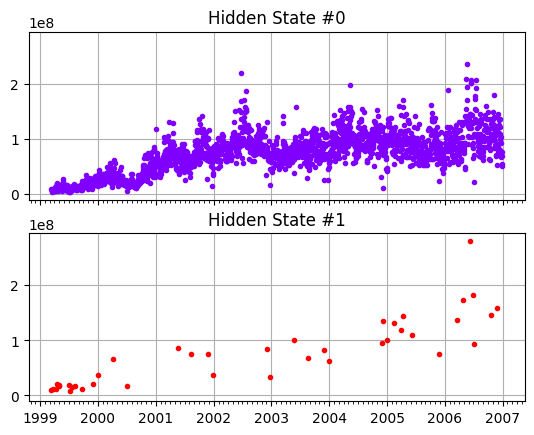

Pickling HMM model...
...HMM model pickled.


In [5]:

rets = np.column_stack([data["Returns"]])

pickle_path = os.path.join(BASE_DIR, "model", f"{sym}.pkl")
print("Data file: {}\nModel file: {}".format(data_path, pickle_path))

# Create the Gaussian Hidden markov Model and fit it
# to the SPY returns data, outputting a score
hmm_model = GaussianHMM(
    n_components=2, covariance_type="full", n_iter=1000
).fit(rets)
print("Model Score:", hmm_model.score(rets))

# Plot the in sample hidden states closing values
plot_in_sample_hidden_states(hmm_model, data)

print("Pickling HMM model...")
pickle.dump(hmm_model, open(pickle_path, "wb"))
print("...HMM model pickled.")
